In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import random

tfd = tfp.distributions
tfb = tfp.bijectors
tf.random.set_seed(1234)

In [2]:
# Hypter parameters
K = 6  # length of the flow
learning_rate = 0.1
iterrations = 1e4

In [3]:
# constants
batch_size=512
DTYPE=tf.float32
NP_DTYPE=np.float32

## Target Density

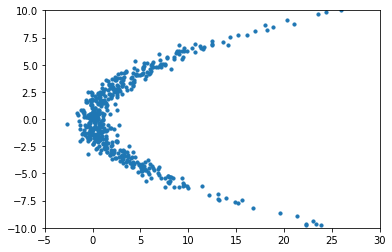

In [4]:
DATASET = 1
if DATASET == 0:
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    X = np.random.multivariate_normal(mean, cov, 2000)
    plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
    dataset = tf.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=X.shape[0])
    dataset = dataset.prefetch(3 * batch_size)
    dataset = dataset.batch(batch_size)
    data_iterator = dataset.make_one_shot_iterator()
    X_train = data_iterator.get_next()
elif DATASET == 1:
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=DTYPE))
    x1_samples = x1.sample()
    X_train = tf.stack([x1_samples, x2_samples], axis=1)
    plt.scatter(X_train[:, 0], X_train[:, 1], s=10)
    plt.xlim([-5, 30])
    plt.ylim([-10, 10])

In [5]:
n_dims = X_train.shape[1]

## Construct Flow

### Step 1. Define Invertible leaky rectified linear transformation

In [6]:
class PReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="p_relu"):
        super(PReLU, self).__init__(
            forward_min_event_ndims=0,
            validate_args=validate_args,
            name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        log_abs_det_J_inv = tf.math.log(tf.abs(J_inv))
        return log_abs_det_J_inv

### Step 2. Define MLP Normalizing Flow

In [7]:
# base distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))
d, r = 2, 2
bijectors = []

# create a fully connected network without non-linear activation function
for i in range(K):
    # define deterministic parameters
    V = tf.Variable(np.random.uniform(-1., 1., size=(d, r)), name='V', dtype=DTYPE)  # factor loading
    shift = tf.Variable(np.random.uniform(-1., 1., size=(d)), name='shift', dtype=DTYPE)  # affine shift
    L = tf.Variable(np.random.uniform(-1., 1., size=(int(d*(d+1)/2))), name='L', dtype=DTYPE)  # lower triangular
    alpha = tf.abs(tf.Variable(np.random.uniform(-1., 1., size=(1)), name='alpha', dtype=DTYPE))+.01

    # Compute Y = g(X; shift, scale) = scale @ X + shift
    bijectors.append(tfb.Affine(
        scale_tril=tfp.math.fill_triangular(L),
        scale_perturb_factor=V,
        shift=shift,
    ))
    bijectors.append(PReLU(alpha=alpha))

In [8]:
# Last layer is affine. Note that tfb.Chain takes a list of bijectors in the *reverse* order
# that they are applied.
mlp_bijector = tfb.Chain(list(reversed(bijectors[:-1])), name='mlp_bijector')
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=mlp_bijector
)

## Visualization (before training)

In [9]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

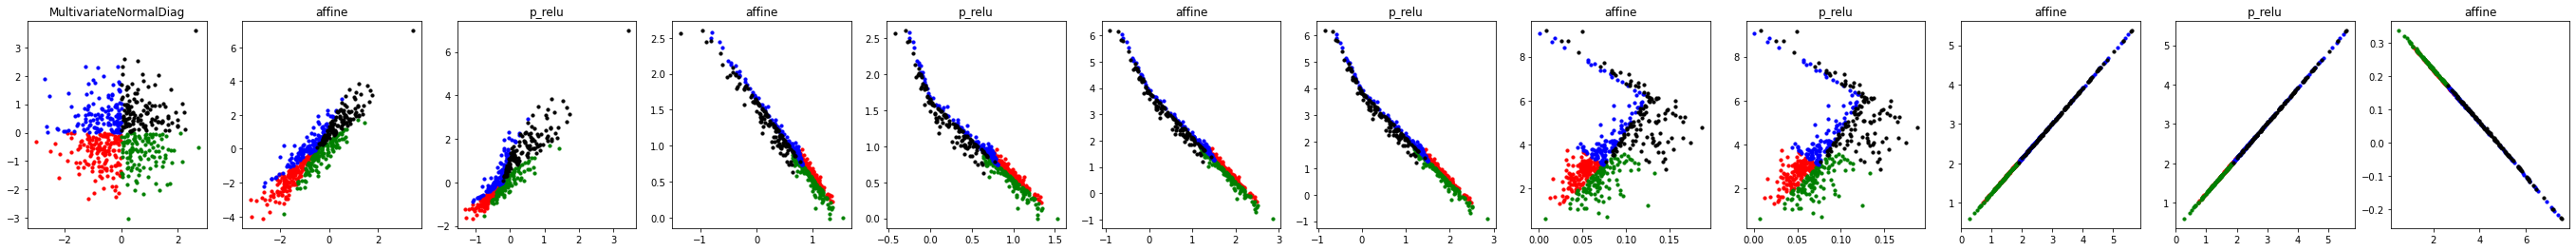

In [10]:
results = samples
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i].numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    # arr[i].set_xlim([-2, 2])
    # arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

## Optimize Flow

In [11]:
# def train(distribution, optimizer, batch):
#     """
#     Train function for density estimation normalizing flows.
#     :param distribution: TensorFlow distribution, e.g. tf.TransformedDistribution.
#     :param optimizer: TensorFlow keras optimizer, e.g. tf.keras.optimizers.Adam(..)
#     :param batch: Batch of the train data.
#     :return: loss.
#     """
#     with tf.GradientTape() as tape:
#         loss = -tf.reduce_mean(distribution.log_prob(batch)) # negative log likelihood
#         gradients = tape.gradient(loss, distribution.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, distribution.trainable_variables))
#         return loss

In [12]:
# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # optimizer

In [14]:
NUM_STEPS = int(iterrations)
global_step = []
np_losses = []

x_ = tf.keras.layers.Input(shape=(X_train.shape[1], ), dtype=tf.float32)
log_prob_ = dist.log_prob(x_)
model = tf.keras.Model(x_, log_prob_)
model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss=lambda _, log_prob: -log_prob)
_ = model.fit(x=X_train,
              y=np.zeros((X_train.shape[0], 0), dtype=np.float32),
              batch_size= X_train.shape[0],
              epochs=50,
              steps_per_epoch=1,
              verbose=1,
              shuffle=True)

Train on 512 samples
Epoch 1/50
512/512 [==============================] - 2s 5ms/sample - loss: 64811504.0000
Epoch 2/50
512/512 [==============================] - 0s 282us/sample - loss: 64811504.0000
Epoch 3/50
512/512 [==============================] - 0s 287us/sample - loss: 64811504.0000
Epoch 4/50
512/512 [==============================] - 0s 284us/sample - loss: 64811504.0000
Epoch 5/50
512/512 [==============================] - 0s 282us/sample - loss: 64811508.0000
Epoch 6/50
512/512 [==============================] - 0s 281us/sample - loss: 64811504.0000
Epoch 7/50
512/512 [==============================] - 0s 283us/sample - loss: 64811512.0000
Epoch 8/50
512/512 [==============================] - 0s 284us/sample - loss: 64811504.0000
Epoch 9/50
512/512 [==============================] - 0s 299us/sample - loss: 64811504.0000
Epoch 10/50
512/512 [==============================] - 0s 282us/sample - loss: 64811496.0000
Epoch 11/50
512/512 [==============================] - 0s 28

In [ ]:
plt.plot(np_losses)

In [ ]:
results = samples
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i].numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')

    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')

    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')

    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    
    arr[i].set_xlim([-5, 30])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])
plt.show()

In [ ]:
X1 = dist.sample(1000)
plt.scatter(X1[:, 0], X1[:, 1], color='green', s=2)
arr[i].set_xlim([-5, 30])
arr[i].set_ylim([-10, 10])
plt.show()

In [ ]:
plt.plot(np_losses, c='red')
plt.xlabel('Step')
plt.ylabel('Negative Log-Likelihood')